Add Potency column to filtered train set. Train set is from 1_filter folder 

In [1]:
import pandas as pd

# File paths for input files
file1 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/1_filter/train_class.csv"  # Path to the first CSV file
file2 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/descriptors_all.csv"  # Path to the second CSV file

# Output file
output_file = "inputs/train_class_filter_wPotency.csv"

# Read the CSV files into pandas DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Ensure only Molecule ChEMBL ID and IC50 columns are used from file2
#df2 = df2[["Molecule ChEMBL ID", "-logIC50"]]  # Adjust "IC50" to the actual column name in file2
df2 = df2[["Molecule ChEMBL ID", "Potency"]]  # Adjust "IC50" to the actual column name in file2

# Merge the two files based on the "Molecule ChEMBL ID" column, keeping all rows in df1
merged_df = pd.merge(df1, df2, on="Molecule ChEMBL ID", how="left")  # Use "left" join to keep all rows from file1

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(output_file, index=False)

print(f"Merged file saved to {output_file}")


Merged file saved to inputs/train_class_filter_wPotency.csv




This script performs Factor analysis (FA) for dimensionality reduction and feature selection on a the classification training data set of molecular descriptors. 

Dimensionality Reduction with FA:
Uses PCA to compute eigenvalues for all components to visualize variance explained.
Outputs a scree plot showing the variance explained by each principal component.
Select number of components based on the elblow of the scree plot (e.g. 15) 

Factor Loadings and Feature Selection:
Extracts factors and sorts them by absolute values.
Dynamically selects features using a threshold based on the mean and standard deviation of absolute loadings.
Saves sorted loadings and selected features to CSV files for training model (we eventually chose reduced features from PCA in this project since it seems to select more relevant features)


Visualizes the pairs of principal components colored by Potency categories (High, Medium, Low).


Explained Variance by Factor: [0.06759697 0.06754268 0.06752762 0.06742878 0.06733163 0.06718111
 0.06711604 0.06691657 0.06679249 0.0665012  0.06625666 0.06594351
 0.06579903 0.06531668 0.06474902]
Number of factors selected: 15


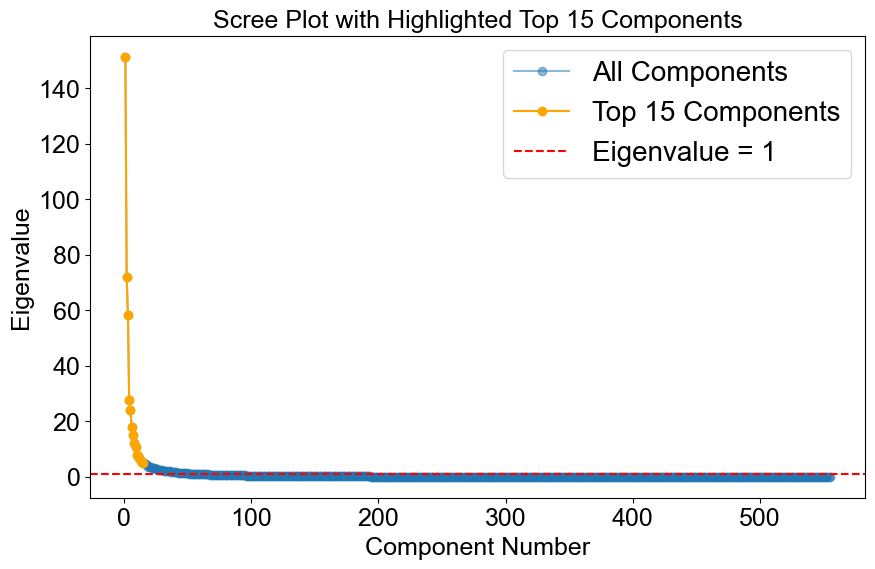

Factor Loadings:
                         Factor1   Factor2   Factor3   Factor4   Factor5  \
PMI1                  -0.809840 -0.018579  0.175812 -0.322123 -0.165665   
PMI2                  -0.526419  0.166835 -0.664214  0.256049 -0.123192   
Asphericity            0.386275  0.084351 -0.716913  0.369212 -0.136210   
Eccentricity           0.273857  0.071919 -0.660131  0.292457 -0.179410   
InertialShapeFactor    0.827582 -0.041078 -0.248396  0.107776 -0.089140   
...                         ...       ...       ...       ...       ...   
saturatedCarbocycles  -0.142930  0.367108  0.102998 -0.110475  0.071584   
saturatedHeterocycles  0.007794  0.096335 -0.250324  0.314289  0.109437   
satureatedRings       -0.108466  0.352095 -0.076430  0.110907  0.125925   
ringCount             -0.690260  0.150070  0.081404  0.138928 -0.241025   
molLogP               -0.640300  0.114387  0.187743 -0.182107 -0.033430   

                        Factor6   Factor7   Factor8   Factor9  Factor10  \
PMI1  

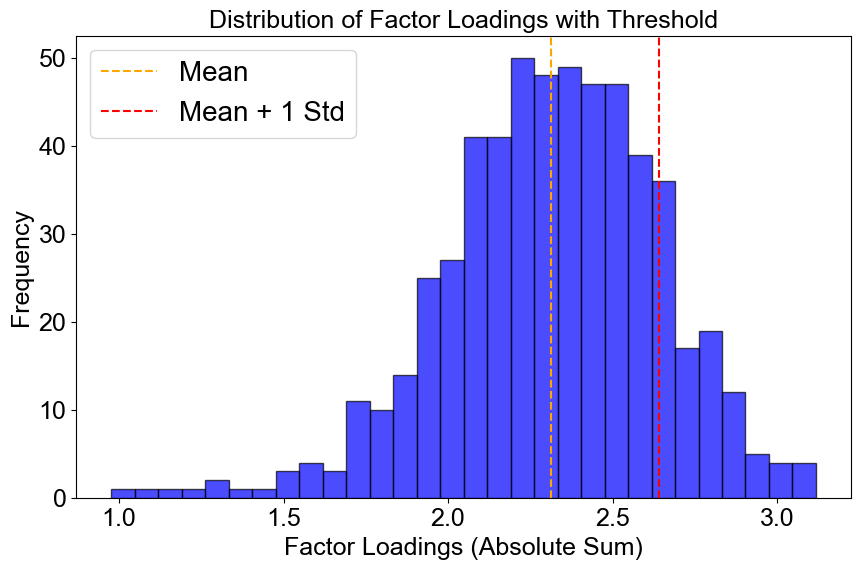

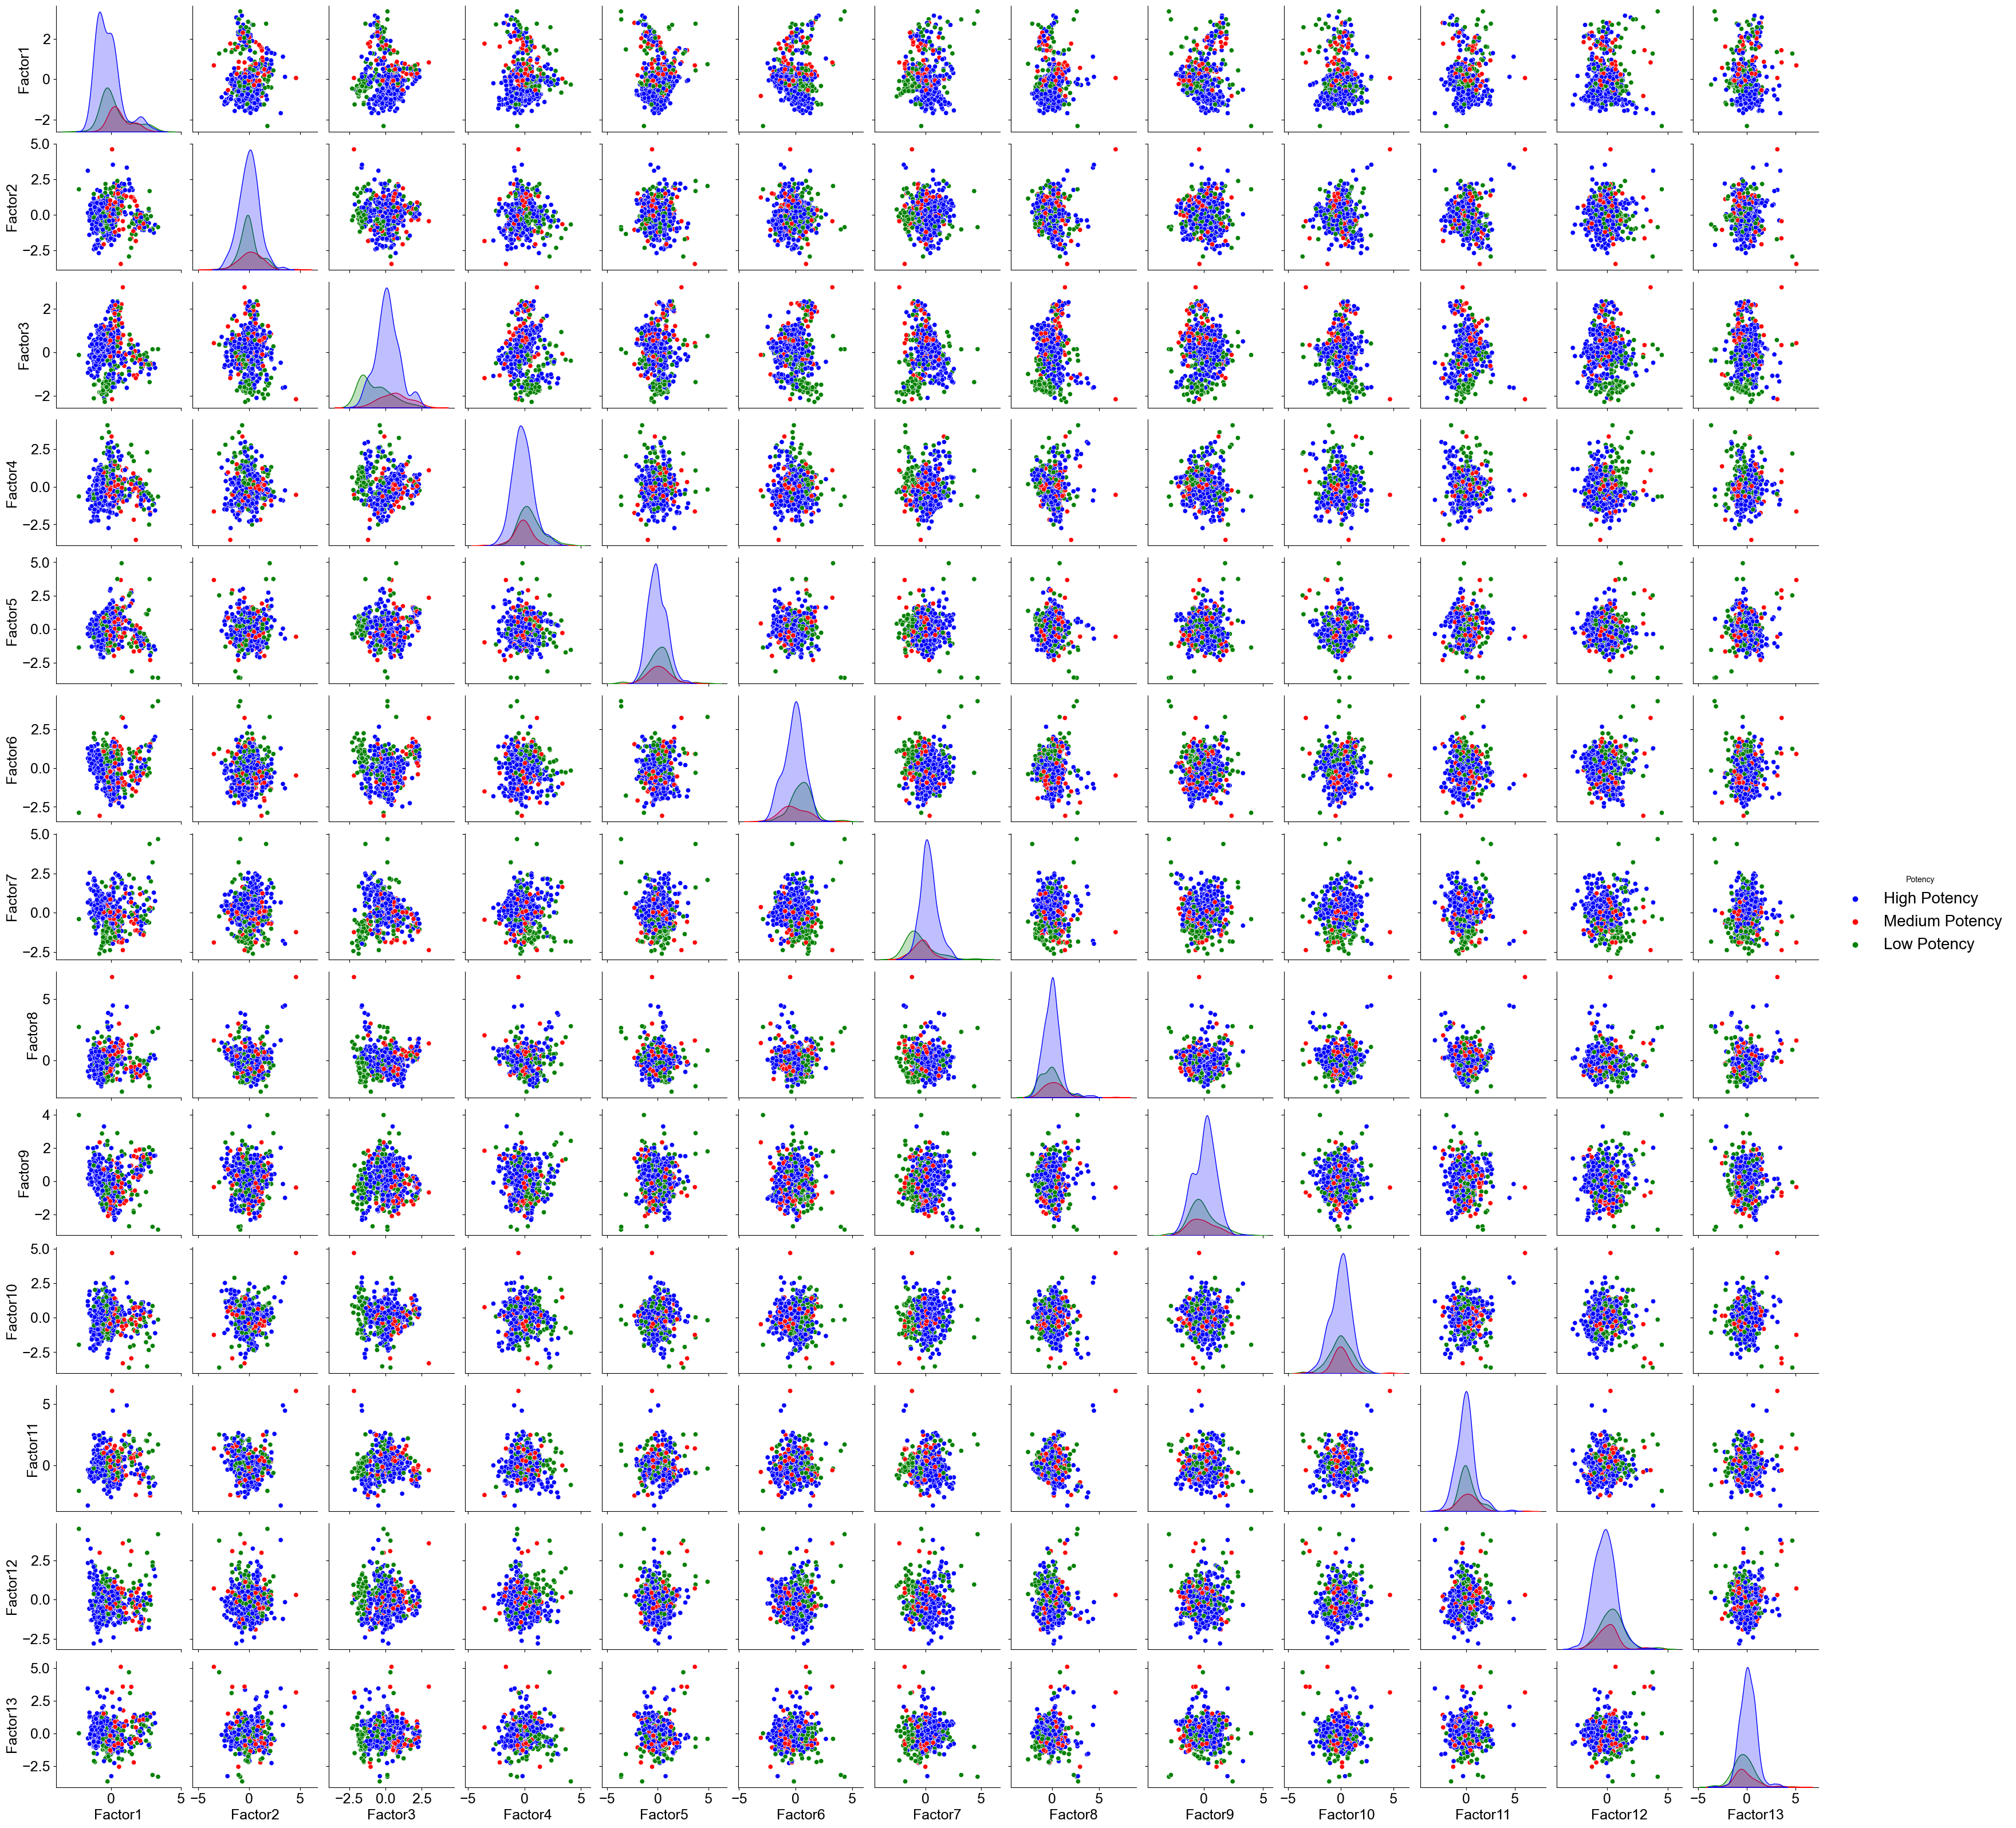

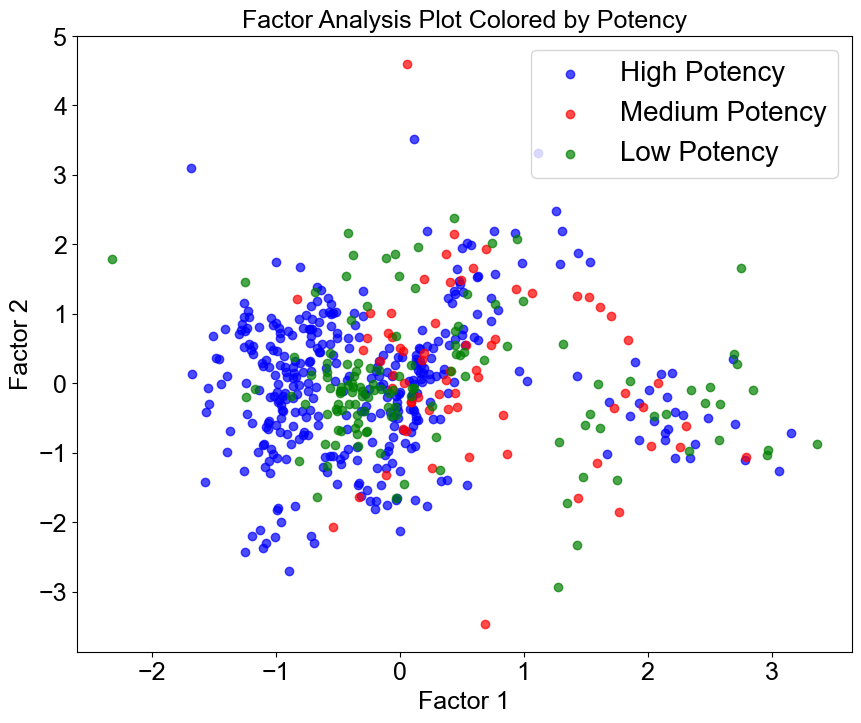

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure global font settings to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['axes.titlesize'] = 18  # Font size for titles
rcParams['axes.labelsize'] = 18  # Font size for axis labels
rcParams['xtick.labelsize'] = 18  # Font size for tick labels
rcParams['ytick.labelsize'] = 18  # Font size for tick labels
rcParams['legend.fontsize'] = 20  # Adjust legend font size

# 1. Load data
data = pd.read_csv("inputs/train_class_filter_wPotency.csv")
data['Potency'] = data['Potency'].str.split('\n').str[0].str.strip()

# Separate features and target variable
X = data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
y = data['Potency']  # Target variable

# 2. Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Calculate eigenvalues using PCA (for scree plot)
pca = PCA().fit(X_scaled)
eigenvalues = pca.explained_variance_

# 4. Apply Factor Analysis
num_factors = 15  # Adjust based on scree plot or domain knowledge
fa = FactorAnalysis(n_components=num_factors, random_state=42)
X_factors = fa.fit_transform(X_scaled)

# 5. Explained Variance (Approximation for FA)
explained_variance = np.var(X_factors, axis=0) / np.sum(np.var(X_factors, axis=0))
print("Explained Variance by Factor:", explained_variance)
print(f"Number of factors selected: {num_factors}")

#6
# Plot all eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', label="All Components", alpha=0.5)

# Highlight the first 15 components
plt.plot(range(1, num_factors + 1), eigenvalues[:num_factors], marker='o', color='orange', label="Top 15 Components")
plt.axhline(y=1, color='red', linestyle='--', label="Eigenvalue = 1")

plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot with Highlighted Top 15 Components")
plt.legend()
plt.savefig("Scree_plot_with_highlighted_top15.png", format='png', dpi=300)
plt.show()

# 7. Inspect Factor Loadings
factor_loadings = pd.DataFrame(fa.components_.T, index=X.columns, columns=[f'Factor{i+1}' for i in range(num_factors)])
print("Factor Loadings:\n", factor_loadings)

# Save sorted factor loadings
sorted_factor_loadings = factor_loadings.abs().sum(axis=1).sort_values(ascending=False)
sorted_factor_loadings.to_csv("sorted_factor_loadings.csv", header=True)

# 8. Define a dynamic threshold for feature selection
mean_loading = sorted_factor_loadings.mean()
std_loading = sorted_factor_loadings.std()
threshold = mean_loading + std_loading  # Threshold: mean + 1 std
print(f"Dynamic threshold (mean + 1 std): {threshold}")

# Select features based on the threshold
selected_features = sorted_factor_loadings[sorted_factor_loadings > threshold].index.tolist()
print(f"Number of features selected with threshold {threshold}: {len(selected_features)}")

# Create a DataFrame with selected features
selected_columns = ['Molecule ChEMBL ID', 'Potency'] + selected_features
selected_features_df = data[selected_columns]

# Save the selected features
selected_features_df.to_csv("selected_features_with_factors.csv", index=False)

# 9. Visualize the Distribution of Factor Loadings
plt.figure(figsize=(10, 6))
plt.hist(sorted_factor_loadings, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_loading, color='orange', linestyle='--', label='Mean')
plt.axvline(threshold, color='red', linestyle='--', label='Mean + 1 Std')
plt.xlabel("Factor Loadings (Absolute Sum)")
plt.ylabel("Frequency")
plt.title("Distribution of Factor Loadings with Threshold")
plt.legend()
plt.savefig("Factor_Loadings_Distribution.png", dpi=300)
plt.show()

# 10. Save Transformed Factor Data
X_factors_df = pd.DataFrame(X_factors, columns=[f'Factor{i+1}' for i in range(num_factors)])
X_factors_df.insert(0, 'Molecule ChEMBL ID', data['Molecule ChEMBL ID'])
X_factors_df.insert(1, 'Potency', data['Potency'])
X_factors_df.to_csv("transformed_reduced_dim_data_with_factors.csv", index=False)

# 11. Pair Plot of Top Factors
palette = {
    "High Potency": 'blue',
    "Medium Potency": 'red',
    "Low Potency": 'green'
}

pair_plot = sns.pairplot(
    X_factors_df.iloc[:, :15],  # Adjust the number of factors for the pair plot
    hue='Potency',
    palette=palette,
    diag_kind='kde'  # Kernel density estimate for diagonal plots
)
pair_plot.fig.savefig("All_factors_PCa_PCb.png", format='png', dpi=300)
plt.show()

# 12. Scatter Plot for Factors
plt.figure(figsize=(10, 8))
for category, color in palette.items():
    subset = X_factors_df[X_factors_df['Potency'] == category]
    plt.scatter(
        subset['Factor1'], subset['Factor2'],
        c=color,
        label=category,
        alpha=0.7
    )
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.title("Factor Analysis Plot Colored by Potency")
plt.legend()
plt.savefig("Factor1_Factor2_Plot.png", dpi=300)
plt.show()
